<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Hard Negative Sampling for Object Detection

You built an object detection model, evaluated it on a test set, and are happy with its accuracy. Now you deploy the model in a real-world application and you may find that the model over-fires heavily, i.e. it detects objects where none are.

This is a common problem in machine learning because our training set only contains a limited number of images, which is not sufficient to model the appearance of every object and every background in the world. Hard negative sampling (or hard negative mining) is a useful technique to address this problem. It is a way to make the model more robust to over-fitting by identifying images which are hard for the model and hence should be added to the training set. 

The technique is widely used when one has a large number of negative images however adding all to the training set would cause (i) training to become too slow; and (ii) overwhelm training with too high a ratio of negatives to positives. For many negative images the model likely already performs well and hence adding them to the training set would not improve accuracy. Therefore, we try to identify those negative images where the model is incorrect.

Note that hard-negative mining is a special case of active learning where the task is to identify images which are hard for the model, annotate these images with the ground truth label, and to add them to the training set. *Hard* could be defined as the model being wrong, or as the model being uncertain about a prediction.


# Overview

In this notebook, we train our model on a training set <i>T</i> as usual, test the model on un-seen negative candidate images <i>U</i>, and see on which images in <i>U</i> the model over-fires. These images are then introduces into the training set <i>T</i> and the model is re-trained. As dataset, we use the  *fridge objects* images (`watter_bottle`, `carton`, `can`, and `milk_bottle`), similar to the [01_training_introduction](./01_training_introduction.ipynb) notebook. 
<img src="./media/hard_neg.jpg" width="600"/>

The overall hard negative mining process is as follows: 
* First, prepare training set <i>T</i> and negative-candidate set <i>U</i>. A small proportion of both sets are set aside for evaluation.
* Second, load a pre-trained detection model.
* Next, mine hard negatives by following steps as shown in the figure:
    1. Train the model on <i>T</i>.
    2. Score the model on <i>U</i>.
    3. Identify `NEGATIVE_NUM` images in <i>U</i> where the model is most incorrect and add to <i>T</i>.
* Finally, repeat these steps until the model stops improving.

In [1]:
import sys
sys.path.append("../../")
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import scrapbook as sb
import torch
import torchvision
from torchvision import transforms

from utils_cv.classification.data import Urls as UrlsIC
from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import which_processor, is_windows
from utils_cv.detection.data import Urls as UrlsOD
from utils_cv.detection.dataset import DetectionDataset, get_transform
from utils_cv.detection.model import DetectionLearner, get_pretrained_fasterrcnn
from utils_cv.detection.plot import plot_detection_vs_ground_truth, plot_grid 

# Change matplotlib backend so that plots are shown on windows machines
if is_windows():
    plt.switch_backend('TkAgg')

print(f"TorchVision: {torchvision.__version__}")
which_processor()

TorchVision: 0.4.0a0
Torch is using GPU: Tesla V100-PCIE-16GB


In [2]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Default parameters. Choose `NEGATIVE_NUM` so that the number of negative images to be added at each iteration corresponds to roughly 10-20% of the total number of images in the training set. If `NEGATIVE_NUM` is too low, then too few hard negatives get added to make a noticeable difference.

In [3]:
# Path to training images, and to the negative images 
DATA_PATH = unzip_url(UrlsOD.fridge_objects_path, exist_ok=True)
NEG_DATA_PATH = unzip_url(UrlsIC.fridge_objects_negatives_path, exist_ok=True)

# Number of negative images to add to the training set after each negative mining iteration. 
# Here set to 10, but this value should be around 10-20% of the total number of images in the training set.
NEGATIVE_NUM = 10

# Model parameters corresponding to the "fast_inference" parameters in the 03_training_accuracy_vs_speed notebook.
EPOCHS = 10
LEARNING_RATE = 0.005
IM_SIZE = 600
BATCH_SIZE = 2 

# Use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using torch device: {device}")
assert str(device)=="cuda", "Model evaluation requires CUDA capable GPU"

Using torch device: cuda


## 1. Prepare datasets

We prepare our datasets in the following way:
* Training images in `data.train_ds` which includes initially only *fridge objects* images, and after running hard-negative mining also negative images.
* Negative candidate images in `neg_data.train_ds`.
* Test images in `data.test_ds` to evaluate accuracy on *fridge objects* images, and in `neg_data.test_ds` to evaluate how often the model misfires on images which do not contain an object-of-interest.

In [4]:
# Model training dataset T, split into 75% training and 25% test
data = DetectionDataset(DATA_PATH, train_pct=0.75)
print(f"Positive dataset: {len(data.train_ds)} training images and {len(data.test_ds)} test images.")

# Negative images split into hard-negative mining candidates U, and a negative test set.
# Setting "allow_negatives=True" since the negative images don't have an .xml file with ground truth annotations
neg_data = DetectionDataset(NEG_DATA_PATH, train_pct=0.80, batch_size=BATCH_SIZE, 
                            im_dir = "", allow_negatives = True, 
                            train_transforms = get_transform(train=False))
print(f"Negative dataset: {len(neg_data.train_ds)} candidates for hard negative mining and {len(neg_data.test_ds)} test images.") 

Positive dataset: 96 training images and 32 test images.
Negative dataset: 52 candidates for hard negative mining and 12 test images.


## 2. Prepare a model

Initialize a pre-trained Faster R-CNN model similar to the [01_training_introduction](./01_training_introduction.ipynb) notebook.

In [5]:
# Pre-trained Faster R-CNN model
detector = DetectionLearner(data, im_size=IM_SIZE)

In [6]:
# Record after each mining iteration the validation accuracy and how many objects were found in the negative test set
valid_accs = []
num_neg_detections = []

## 3. Train the model on *T*

<a id='train'></a>

Model training. As described at the start of this notebook, you likely need to repeat the steps from here until the end of the notebook several times to achieve optimal results.

In [7]:
# Fine-tune model. After each epoch prints the accuracy on the validation set.
detector.fit(EPOCHS, lr=LEARNING_RATE, print_freq=30)

Epoch: [0]  [ 0/48]  eta: 0:02:55  lr: 0.000111  loss: 1.9822 (1.9822)  loss_classifier: 1.7910 (1.7910)  loss_box_reg: 0.1852 (0.1852)  loss_objectness: 0.0009 (0.0009)  loss_rpn_box_reg: 0.0051 (0.0051)  time: 3.6664  data: 0.9532  max mem: 873
Epoch: [0]  [30/48]  eta: 0:00:03  lr: 0.003300  loss: 0.5442 (0.8285)  loss_classifier: 0.2600 (0.5711)  loss_box_reg: 0.2222 (0.2452)  loss_objectness: 0.0038 (0.0056)  loss_rpn_box_reg: 0.0053 (0.0067)  time: 0.0897  data: 0.0001  max mem: 1142
Epoch: [0]  [47/48]  eta: 0:00:00  lr: 0.005000  loss: 0.4085 (0.6722)  loss_classifier: 0.1996 (0.4373)  loss_box_reg: 0.1914 (0.2229)  loss_objectness: 0.0016 (0.0044)  loss_rpn_box_reg: 0.0084 (0.0076)  time: 0.0883  data: 0.0000  max mem: 1142
Epoch: [0] Total time: 0:00:08 (0.1697 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:12  model_time: 0.1322 (0.1322)  evaluator_time: 0.0061 (0.0061)  time: 0.8120  data: 0.6718  max mem: 1142
Test:  [15/16]  eta: 0:00:00  model_time: 0

Epoch: [4]  [ 0/48]  eta: 0:00:59  lr: 0.005000  loss: 0.0436 (0.0436)  loss_classifier: 0.0244 (0.0244)  loss_box_reg: 0.0145 (0.0145)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0046 (0.0046)  time: 1.2393  data: 0.9684  max mem: 1142
Epoch: [4]  [30/48]  eta: 0:00:02  lr: 0.005000  loss: 0.0350 (0.0397)  loss_classifier: 0.0207 (0.0221)  loss_box_reg: 0.0098 (0.0125)  loss_objectness: 0.0001 (0.0003)  loss_rpn_box_reg: 0.0043 (0.0048)  time: 0.0961  data: 0.0001  max mem: 1142
Epoch: [4]  [47/48]  eta: 0:00:00  lr: 0.005000  loss: 0.0371 (0.0419)  loss_classifier: 0.0189 (0.0229)  loss_box_reg: 0.0113 (0.0137)  loss_objectness: 0.0001 (0.0004)  loss_rpn_box_reg: 0.0048 (0.0049)  time: 0.0878  data: 0.0000  max mem: 1142
Epoch: [4] Total time: 0:00:05 (0.1237 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:12  model_time: 0.0840 (0.0840)  evaluator_time: 0.0047 (0.0047)  time: 0.8114  data: 0.7207  max mem: 1142
Test:  [15/16]  eta: 0:00:00  model_time: 

Epoch: [8]  [ 0/48]  eta: 0:01:00  lr: 0.000500  loss: 0.0149 (0.0149)  loss_classifier: 0.0095 (0.0095)  loss_box_reg: 0.0036 (0.0036)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0016 (0.0016)  time: 1.2570  data: 0.9449  max mem: 1142
Epoch: [8]  [30/48]  eta: 0:00:02  lr: 0.000500  loss: 0.0207 (0.0257)  loss_classifier: 0.0137 (0.0153)  loss_box_reg: 0.0048 (0.0068)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0027 (0.0033)  time: 0.0979  data: 0.0001  max mem: 1142
Epoch: [8]  [47/48]  eta: 0:00:00  lr: 0.000500  loss: 0.0222 (0.0259)  loss_classifier: 0.0145 (0.0157)  loss_box_reg: 0.0063 (0.0067)  loss_objectness: 0.0001 (0.0003)  loss_rpn_box_reg: 0.0026 (0.0032)  time: 0.0883  data: 0.0001  max mem: 1142
Epoch: [8] Total time: 0:00:06 (0.1267 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:13  model_time: 0.0708 (0.0708)  evaluator_time: 0.0040 (0.0040)  time: 0.8188  data: 0.7420  max mem: 1142
Test:  [15/16]  eta: 0:00:00  model_time: 

Show the accuracy on the validation set for this and all previous mining iterations.

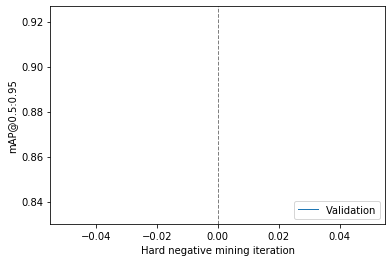

In [8]:
# Get validation accuracy on test set at IOU=0.5:0.95
acc = float(detector.ap[-1])
valid_accs.append(acc)

# Plot validation accuracy versus number of hard-negative mining iterations
from utils_cv.common.plot import line_graph
line_graph(
    values=(valid_accs), 
    labels=("Validation"),
    x_guides=range(len(valid_accs)),
    x_name="Hard negative mining iteration",
    y_name="mAP@0.5:0.95",
)

## 4. Score the model on *U* 

Run inference on all negative candidate images. The images where the model is most incorrect will later be added as hard negatives to the training set.

In [9]:
detections = detector.predict_dl(neg_data.train_dl, threshold=0)
detections[0]

['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can

{'idx': 53,
 'det_bboxes': [{Bbox object: [left=87, top=0, right=386, bottom=557] | <carton> | label:4 | path:/home/jiata/code/computervision/data/fridgeObjectsNegative/IMG_1852.jpg} | score: 0.9575940370559692,
  {Bbox object: [left=0, top=16, right=142, bottom=546] | <carton> | label:4 | path:/home/jiata/code/computervision/data/fridgeObjectsNegative/IMG_1852.jpg} | score: 0.5699040293693542,
  {Bbox object: [left=224, top=0, right=399, bottom=433] | <carton> | label:4 | path:/home/jiata/code/computervision/data/fridgeObjectsNegative/IMG_1852.jpg} | score: 0.2580847144126892,
  {Bbox object: [left=6, top=365, right=158, bottom=561] | <can> | label:2 | path:/home/jiata/code/computervision/data/fridgeObjectsNegative/IMG_1852.jpg} | score: 0.24723641574382782,
  {Bbox object: [left=113, top=3, right=256, bottom=526] | <carton> | label:4 | path:/home/jiata/code/computervision/data/fridgeObjectsNegative/IMG_1852.jpg} | score: 0.1436130255460739,
  {Bbox object: [left=128, top=212, right=3

Count how many objects were detected in the negative test set. This number typically goes down dramatically after a few mining iterations, and is an indicator how much the model over-fires on unseen images.

['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']
['milk_bottle', 'can', 'water_bottle', 'carton']


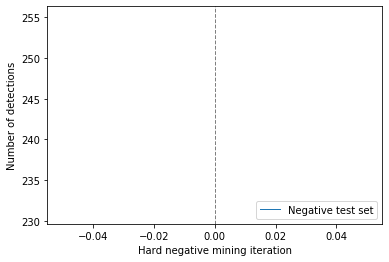

In [10]:
# Count number of mis-detections on negative test set
test_detections = detector.predict_dl(neg_data.test_dl, threshold=0)
bbox_scores = [bbox.score for det in test_detections for bbox in det['det_bboxes']]
num_neg_detections.append(len(bbox_scores))

# Plot
from utils_cv.common.plot import line_graph
line_graph(
    values=(num_neg_detections), 
    labels=("Negative test set"),
    x_guides=range(len(num_neg_detections)), 
    x_name="Hard negative mining iteration",
    y_name="Number of detections",
)

## 5. Hard negative mining

Use the negative candidate images where the model is most incorrect as hard negatives. 

In [11]:
# For each image, get maximum score (i.e. confidence in the detection) over all detected bounding boxes in the image
max_scores = []
for idx, detection in enumerate(detections):
    if len(detection['det_bboxes']) > 0:
        max_score = max([d.score for d in detection['det_bboxes']])
    else:
        max_score = float('-inf')
    max_scores.append(max_score)

In [12]:
# Use the n images with highest maximum score as hard negatives
hard_im_ids = np.argsort(max_scores)[::-1]
hard_im_ids = hard_im_ids[:NEGATIVE_NUM]
hard_im_scores =[max_scores[i] for i in hard_im_ids]
print(f"Indentified {len(hard_im_scores)} hard negative images with detection scores in range {min(hard_im_scores)} to {max(hard_im_scores):4.2f}")

Indentified 10 hard negative images with detection scores in range 0.9907510876655579 to 1.00


Plot some of the identified hard negatives images. This will likely mistake objects which were not part of the training set as the objects-of-interest.

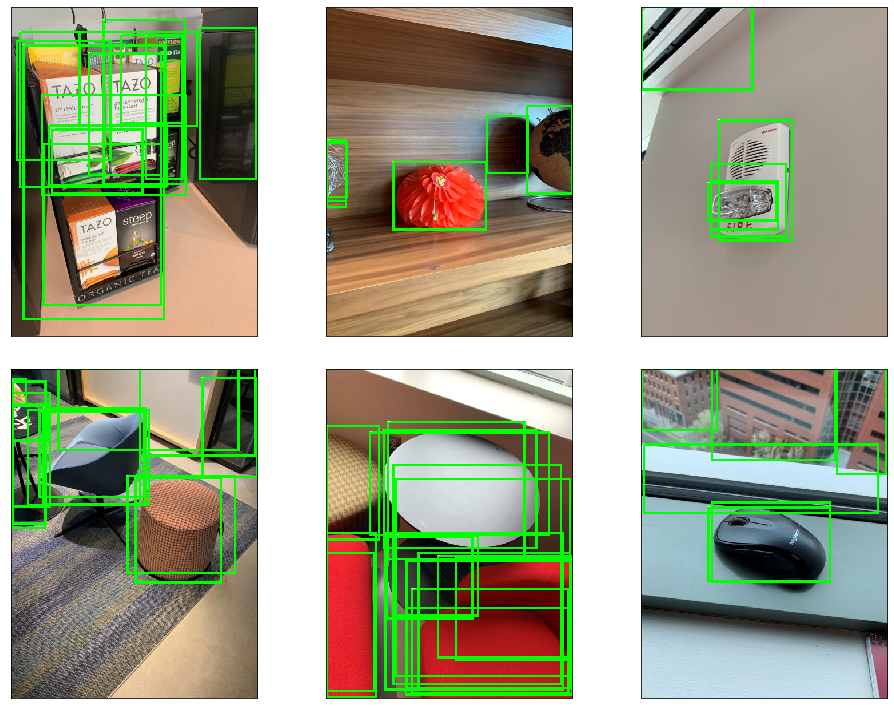

In [13]:
# Get image paths and ground truth boxes for the hard negative images
dataset_ids = [detections[i]['idx'] for i in hard_im_ids]
im_paths = [neg_data.train_ds.dataset.im_paths[i] for i in dataset_ids]
gt_bboxes = [neg_data.train_ds.dataset.anno_bboxes[i] for i in dataset_ids]

# Plot
det_bboxes = [detections[i]['det_bboxes'] for i in hard_im_ids]
plot_grid(plot_detection_vs_ground_truth, zip(im_paths, gt_bboxes, det_bboxes), rows=2, cols=3)

## 6. Add hard negatives to *T*

We now add the identified hard negative images to the training set.

In [14]:
# Add identified hard negatives to training set
data.add_images(im_paths, gt_bboxes, target = "train")
print(f"Added {len(im_paths)} hard negative images. Now: {len(data.train_ds)} training images and {len(data.test_ds)} test images")
print(f"Completed {len(valid_accs)} hard negative iterations.")

# Preserve some of the notebook outputs
sb.glue("valid_accs", valid_accs)
sb.glue("hard_im_scores", list(hard_im_scores))

Added 10 hard negative images. Now: 106 training images and 32 test images
Completed 1 hard negative iterations.


## Repeat

Now, **repeat** all steps starting from "[3. Train the model on T](#train)" to re-train the model and the training set T with added and add more hard negative images to the training set. **Stop** once the accuracy `valid_accs` stopped improving and if the number of (mis)detections in the negative test set `num_neg_detections` stops decreasing. 